## The Purpose of This Notebook

This notebook is designed to give users some experience handling objects of the src package. The classes below have been slighly altered from the actual package code in order to more clearly illustrate how the objects work together. This notebook should be used in the winter school only, and users should refer to the Tutorial notebook for example usage of the actual code.

In [21]:
import matplotlib.pyplot as plt
import copy
%matplotlib inline

### \__init\__.py file

In [29]:
""" Project initialization and common objects. """

import logging
import os
from pathlib import Path
import re
import sys
import pickle
from sklearn.externals import joblib

logging.basicConfig(
    stream=sys.stdout,
    format='[%(levelname)s][%(module)s] %(message)s',
    level=os.getenv('LOGLEVEL', 'info').upper()
)

workdir = Path(os.getenv('WORKDIR', '.'))

cachedir = workdir / 'cache'
cachedir.mkdir(parents=True, exist_ok=True)

#: Sets the collision systems for the entire project,
#: where each system is a string of the form
#: ``'<projectile 1><projectile 2><beam energy in GeV>'``,
#: such as ``'PbPb2760'``, ``'AuAu200'``, ``'pPb5020'``.
#: Even if the project uses only a single system,
#: this should still be a list of one system string.
systems = ['PbPb5020']


#: Design attribute. This is a list of 
#: strings describing the inputs.
#: The default is for the example data.
keys = ['lambda_jet','alpha_s'] #labels in words

#: Design attribute. This is a list of input
#: labels in LaTeX for plotting.
#: The default is for the example data. 
labels = [r'\Lambda_{jet}',r'\alpha_s}'] #labels in LaTeX

#: Design attribute. This is list of tuples of 
#: (min,max) for each design input.
#: The default is for the example data.
ranges = [(0.01,0.3),(0.05,0.35)]

#: Design array to use - should be a numpy array.
#: Keep at None generate a Latin Hypercube with above (specified) range.
#: Design array for example is commented under default.
#design_array = None
design_array = pickle.load((cachedir / 'lhs/design_s.p').open('rb'))

#: Dictionary of the model output.
#: Form MUST be data_list[system][observable][subobservable][{'Y': ,'x': }].
#:     'Y' is an (n x p) numpy array of the output.
#:
#:     'x' is a (1 x p) numpy array of numeric index of columns of Y (if exists). In the example data, x is p_T. 
#: This MUST be changed from None - no built-in default exists. Uncomment the line below default for example.
#data_list = None
data_list_loaded = pickle.load((cachedir / 'model/main/full_data_dict.p').open('rb'))

#: Dictionary for the model validation output
#: Must be the same for as the model output dictionary
#data_list_val = pickle.load((cachedir / 'model/validation/data_dict_val.p').open('rb'))
data_list = None

#: Dictionary of the experimental data.
#: Form MUST be exp_data_list[system][observable][subobservable][{'y':,'x':,'yerr':{'stat':,'sys'}}].
#:      'y' is a (1 x p) numpy array of experimental data.
#:
#:      'x' is a (1 x p) numpy array of numeric index of columns of Y (if exists). In the example data, x is p_T.
#:
#:      'yerr' is a dictionary with keys 'stat' and 'sys'.
#:
#:      'stat' is a (1 x p) array of statistical errors.
#:
#:      'sys' is a (1 x p) array of systematic errors.
#: This MUST be changed from None - no built-in default exists. Uncomment the line below default for example.
#exp_data_list = None
exp_data_list = pickle.load((cachedir / 'hepdata/data_list_exp.p').open('rb'))

#: Experimental covariance matrix.
#: Set exp_cov = None to have the script estimate the covariance matrix.
#: Example commented below default.
#exp_cov = None
exp_cov = pickle.load((cachedir / 'hepdata/cov_exp_pbpb5020_30_50.p').open('rb'))


#: Observables to emulate as a list of 2-tuples
#: ``(obs, [list of subobs])``.
observables = [('R_AA',[None])]

def parse_system(system):
    """
    Parse a system string into a pair of projectiles and a beam energy.

    """
    match = re.fullmatch('([A-Z]?[a-z])([A-Z]?[a-z])([0-9]+)', system)
    return match.group(1, 2), int(match.group(3))


class lazydict(dict):
    """
    A dict that populates itself on demand by calling a unary function.

    """
    def __init__(self, function, *args, **kwargs):
        self.function = function
        self.args = args
        self.kwargs = kwargs

    def __missing__(self, key):
        self[key] = value = self.function(key, *self.args, **self.kwargs)
        return value

### design.py file

In [33]:
"""
Generates Latin-hypercube parameter designs.

When run as a script, writes input files for use with my
`heavy-ion collision event generator
<https://github.com/jbernhard/heavy-ion-collisions-osg>`_.
Run ``python -m src.design --help`` for usage information.

.. warning::

    This module uses the R `lhs package
    <https://cran.r-project.org/package=lhs>`_ to generate maximin
    Latin-hypercube samples.  As far as I know, there is no equivalent library
    for Python (I am aware of `pyDOE <https://pythonhosted.org/pyDOE>`_, but
    that uses a much more rudimentary algorithm for maximin sampling).

    This means that R must be installed with the lhs package (run
    ``install.packages('lhs')`` in an R session).

"""

import itertools
import logging
from pathlib import Path
import re
import subprocess

import numpy as np

#from . import cachedir, parse_system, keys, labels, ranges, design_array, systems


def generate_lhs(npoints, ndim, seed):
    """
    Generate a maximin Latin-hypercube sample (LHS) with the given number of
    points, dimensions, and random seed.

    """
    logging.debug(
        'generating maximin LHS: '
        'npoints = %d, ndim = %d, seed = %d',
        npoints, ndim, seed
    )

    cachefile = (
        cachedir / 'lhs' /
        'npoints{}_ndim{}_seed{}.npy'.format(npoints, ndim, seed)
    )

    if cachefile.exists():
        logging.debug('loading from cache')
        lhs = np.load(cachefile)
    else:
        logging.debug('not found in cache, generating using R')
        proc = subprocess.run(
            ['R', '--slave'],
            input="""
            library('lhs')
            set.seed({})
            write.table(maximinLHS({}, {}), col.names=FALSE, row.names=FALSE)
            """.format(seed, npoints, ndim).encode(),
            stdout=subprocess.PIPE,
            check=True
        )

        lhs = np.array(
            [l.split() for l in proc.stdout.splitlines()],
            dtype=float
        )

        cachefile.parent.mkdir(exist_ok=True)
        np.save(cachefile, lhs)

    return lhs


class Design:
    """
    Latin-hypercube model design.

    Creates a design for the given system with the given number of points.
    Creates the main (training) design if `validation` is false (default);
    creates the validation design if `validation` is true.  If `seed` is not
    given, a default random seed is used (different defaults for the main and
    validation designs).

    Public attributes:

    - ``system``: the system string
    - ``projectiles``, ``beam_energy``: system projectile pair and beam energy
    - ``type``: 'main' or 'validation'
    - ``keys``: list of parameter keys
    - ``labels``: list of parameter display labels (for TeX / matplotlib)
    - ``range``: list of parameter (min, max) tuples
    - ``min``, ``max``: numpy arrays of parameter min and max
    - ``ndim``: number of parameters (i.e. dimensions)
    - ``points``: list of design point names (formatted numbers)
    - ``array``: the actual design array

    The class also implicitly converts to a numpy array.

    This is probably the worst class in this project, and certainly the least
    generic.  It will probably need to be heavily edited for use in any other
    project, if not completely rewritten.

    """
    def __init__(self, system, keys=keys, ranges=ranges,array = design_array, labels=labels, npoints=500, validation=False, seed=None):
        self.system = system
        self.projectiles, self.beam_energy = parse_system(system)
        self.type = 'validation' if validation else 'main'
        
        self.keys = keys
        self.range = ranges

       # # 5.02 TeV has ~1.2x particle production as 2.76 TeV
       # # [https://inspirehep.net/record/1410589]
     #   norm_range = {
     #       2760: (8., 20.),
     #       5020: (10., 25.),
     #   }[self.beam_energy]

     #   self.keys, labels, self.range = map(list, zip(*[
     #       ('norm',          r'{Norm}',                      (norm_range   )),
     #       ('trento_p',      r'p',                           ( -0.5,    0.5)),
     #       ('fluct_std',     r'\sigma {fluct}',              (  0.0,    2.0)),
     #       ('nucleon_width', r'w [{fm}]',                    (  0.4,    1.0)),
     #       ('dmin3',         r'd {min} [{fm}]',              (  0.0, 1.7**3)),
     #       ('tau_fs',        r'\tau {fs} [{fm}/c]',          (  0.0,    1.5)),
     #       ('etas_hrg',      r'\eta/s {hrg}',                (  0.1,    0.5)),
     #       ('etas_min',      r'\eta/s {min}',                (  0.0,    0.2)),
     #       ('etas_slope',    r'\eta/s {slope} [{GeV}^{-1}]', (  0.0,    8.0)),
     #       ('etas_crv',      r'\eta/s {crv}',                ( -1.0,    1.0)),
     #       ('zetas_max',     r'\zeta/s {max}',               (  0.0,    0.1)),
     #       ('zetas_width',   r'\zeta/s {width} [{GeV}]',     (  0.0,    0.1)),
     #       ('zetas_t0',      r'\zeta/s T_0 [{GeV}]',         (0.150,  0.200)),
     #       ('Tswitch',       r'T {switch} [{GeV}]',          (0.135,  0.165)),
     #   ]))

        # convert labels into TeX:
        #   - wrap normal text with \mathrm{}
        #   - escape spaces
        #   - surround with $$
        self.labels = [
            re.sub(r'({[A-Za-z]+})', r'\mathrm\1', i)
            .replace(' ', r'\ ')
            .join('$$')
            for i in labels
        ]

        self.ndim = len(self.range)
        self.min, self.max = map(np.array, zip(*self.range))

        # use padded numbers for design point names
        fmt = '{:0' + str(len(str(npoints - 1))) + 'd}'
        self.points = [fmt.format(i) for i in range(npoints)]


        lhsmin = self.min.copy()

        if seed is None:
            seed = 751783496 if validation else 450829120

        if array is None:
            self.array = lhsmin + (self.max - lhsmin)*generate_lhs(
                npoints=npoints, ndim=self.ndim, seed=seed
            )
        else:
            self.array = array
  

    def __array__(self):
        return self.array



    def write_files(self, basedir):
        """
        Write input files for each design point to `basedir`.

        """
        outdir = basedir / self.type / self.system
        outdir.mkdir(parents=True, exist_ok=True)

        for point, row in zip(self.points, self.array):
            kwargs = dict(
                zip(self.keys, row),
                projectiles=self.projectiles,
                cross_section={
                    # sqrt(s) [GeV] : sigma_NN [fm^2]
                    200: 4.2,
                    2760: 6.4,
                    5020: 7.0,
                }[self.beam_energy]
            )
            kwargs.update(
               fluct=1/kwargs.pop('fluct_std')**2,
                dmin=kwargs.pop('dmin3')**(1/3),
            )
            filepath = outdir / point
            with filepath.open('w') as f:
                f.write(self._template.format(**kwargs))
                logging.debug('wrote %s', filepath)

    def print_array(self):
        print('Design is')
        print(self.array)  


## Exercise: Making a Latin-Hypercube Design 

#### a) Make a random design 15 points with given ranges set seed to 150. Plot the second input versus the first

In [34]:
d = Design('PbPb5020',
           array = None, #Hint - look at the __init__.py file above for instructions on how to create a random design
           npoints = 15,
           seed = 150)

    Hint: the array attribute of d returns a numpy array of the design

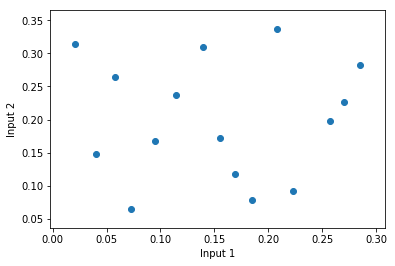

In [35]:
plt.scatter(x = d.array[:,0],
            y = d.array[:,1])
plt.xlabel('Input 1')
plt.ylabel('Input 2')
pass

#### b) Make a Design object with design_array, and plot it

In [36]:
design_obj = Design('PbPb5020',
                    array = design_array, #This comes from the init file
                    keys = keys,
                    labels = labels,
                    ranges = ranges)

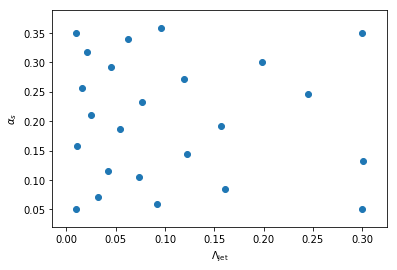

In [37]:
plt.scatter(x = design_obj.array[:,0],
            y = design_obj.array[:,1])
plt.xlabel(design_obj.labels[0]) 
plt.ylabel(design_obj.labels[1])
pass

### emulator.py file

This script will train the Gaussian Process emulators. In the actual code, a Design object is created in the Emulator init() function - in this notebook, a Design object is a parameter of the Emulator object. We will use the above created Design object to make emulators and explore their functionality.

In [38]:
"""
Trains Gaussian process emulators.

When run as a script, allows retraining emulators, specifying the number of
principal components, and other options (however it is not necessary to do this
explicitly --- the emulators will be trained automatically when needed).  Run
``python -m src.emulator --help`` for usage information.

Uses the `scikit-learn <http://scikit-learn.org>`_ implementations of
`principal component analysis (PCA)
<http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html>`_
and `Gaussian process regression
<http://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html>`_.
"""

import logging
import pickle

import numpy as np
from sklearn.decomposition import PCA
from sklearn.externals import joblib
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process import kernels
from sklearn.preprocessing import StandardScaler

#from . import cachedir, lazydict, model, observables
#from .design import Design


class _Covariance:
    """
    Proxy object to extract observable sub-blocks from a covariance array.
    Returned by Emulator.predict().

    """
    def __init__(self, array, slices):
        self.array = array
        self._slices = slices

    def __getitem__(self, key):
        (obs1, subobs1), (obs2, subobs2) = key
        return self.array[
            ...,
            self._slices[obs1][subobs1],
            self._slices[obs2][subobs2]
        ]


class Emulator:
    """
    Multidimensional Gaussian process emulator using principal component
    analysis.

    The model training data are standardized (subtract mean and scale to unit
    variance), then transformed through PCA.  The first `npc` principal
    components (PCs) are emulated by independent Gaussian processes (GPs).  The
    remaining components are neglected, which is equivalent to assuming they
    are standard zero-mean unit-variance GPs.

    This class has become a bit messy but it still does the job.  It would
    probably be better to refactor some of the data transformations /
    preprocessing into modular classes, to be used with an sklearn pipeline.
    The classes would also need to handle transforming uncertainties, which
    could be tricky.

    """


    #Now takes a Design object as required input
    def __init__(self, system, design, data_list, npc=10, nrestarts=0):
        logging.info(
            'training emulator for system %s (%d PC, %d restarts)',
            system, npc, nrestarts,
            'Design is',
            design.array
        )
        
        Y = []
        self._slices = {}
   
        self.observables = observables
    
        # Build an array of all observables to emulate.
        nobs = 0
        for obs, subobslist in self.observables:
            self._slices[obs] = {}
            for subobs in subobslist:
                Y.append(data_list[system][obs][subobs]['Y'])
                n = Y[-1].shape[1]
                self._slices[obs][subobs] = slice(nobs, nobs + n)
                nobs += n

        Y = np.concatenate(Y, axis=1)
        pickle.dump(Y,open('mod_dat.p','wb'))

        self.npc = npc
        self.nobs = nobs
        self.scaler = StandardScaler(copy=False)
        self.pca = PCA(copy=False, whiten=True, svd_solver='full')

        # Standardize observables and transform through PCA.  Use the first
        # `npc` components but save the full PC transformation for later.
        Z = self.pca.fit_transform(self.scaler.fit_transform(Y))[:, :npc]

        self.Z = Z
        # Define kernel (covariance function):
        # Gaussian correlation (RBF) plus a noise term.
        ptp = design.max - design.min
        kernel = (
            1. * kernels.RBF(
                length_scale=ptp,
                length_scale_bounds=np.outer(ptp, (.1, 10))
            ) +
            kernels.WhiteKernel(
                noise_level=.1**2,
                noise_level_bounds=(.01**2, 1)
            )
        )
        # Fit a GP (optimize the kernel hyperparameters) to each PC.
        self.gps = [
            GPR(
                kernel=kernel, alpha=0,
                n_restarts_optimizer=nrestarts,
                copy_X_train=False
            ).fit(design, z)
            for z in Z.T
        ]

        # Construct the full linear transformation matrix, which is just the PC
        # matrix with the first axis multiplied by the explained standard
        # deviation of each PC and the second axis multiplied by the
        # standardization scale factor of each observable.
        self._trans_matrix = (
            self.pca.components_
            * np.sqrt(self.pca.explained_variance_[:, np.newaxis])
            * self.scaler.scale_
        )

        # Pre-calculate some arrays for inverse transforming the predictive
        # variance (from PC space to physical space).

        # Assuming the PCs are uncorrelated, the transformation is
        #
        #   cov_ij = sum_k A_ki var_k A_kj
        #
        # where A is the trans matrix and var_k is the variance of the kth PC.
        # https://en.wikipedia.org/wiki/Propagation_of_uncertainty

        # Compute the partial transformation for the first `npc` components
        # that are actually emulated.
        A = self._trans_matrix[:npc]
        self._var_trans = np.einsum(
            'ki,kj->kij', A, A, optimize=False).reshape(npc, nobs**2)

        # Compute the covariance matrix for the remaining neglected PCs
        # (truncation error).  These components always have variance == 1.
        B = self._trans_matrix[npc:]
        self._cov_trunc = np.dot(B.T, B)

        # Add small term to diagonal for numerical stability.
        self._cov_trunc.flat[::nobs + 1] += 1e-4 * self.scaler.var_

    @classmethod
    def from_cache(cls, system, retrain=False, **kwargs):
        """
        Load the emulator for `system` from the cache if available, otherwise
        train and cache a new instance.

        """
        cachefile = cachedir / 'emulator' / '{}.pkl'.format(system)

        # cache the __dict__ rather than the Emulator instance itself
        # this way the __name__ doesn't matter, e.g. a pickled
        # __main__.Emulator can be unpickled as a src.emulator.Emulator
        if not retrain and cachefile.exists():
            logging.debug('loading emulator for system %s from cache', system)
            emu = cls.__new__(cls)
            emu.__dict__ = joblib.load(cachefile)
            return emu

        emu = cls(system, **kwargs)

        logging.info('writing cache file %s', cachefile)
        cachefile.parent.mkdir(exist_ok=True)
        joblib.dump(emu.__dict__, cachefile, protocol=pickle.HIGHEST_PROTOCOL)

        return emu

    def _inverse_transform(self, Z):
        """
        Inverse transform principal components to observables.

        Returns a nested dict of arrays.

        """
        # Z shape (..., npc)
        # Y shape (..., nobs)
        Y = np.dot(Z, self._trans_matrix[:Z.shape[-1]])
        Y += self.scaler.mean_

        return {
            obs: {
                subobs: Y[..., s]
                for subobs, s in slices.items()
            } for obs, slices in self._slices.items()
        }

    def predict(self, X, return_cov=False, extra_std=0):
        """
        Predict model output at `X`.

        X must be a 2D array-like with shape ``(nsamples, ndim)``.  It is passed
        directly to sklearn :meth:`GaussianProcessRegressor.predict`.

        If `return_cov` is true, return a tuple ``(mean, cov)``, otherwise only
        return the mean.

        The mean is returned as a nested dict of observable arrays, each with
        shape ``(nsamples, n_cent_bins)``.

        The covariance is returned as a proxy object which extracts observable
        sub-blocks using a dict-like interface:

        >>> mean, cov = emulator.predict(X, return_cov=True)

        >>> mean['dN_dy']['pion']
        <mean prediction of pion dN/dy>

        >>> cov[('dN_dy', 'pion'), ('dN_dy', 'pion')]
        <covariance matrix of pion dN/dy>

        >>> cov[('dN_dy', 'pion'), ('mean_pT', 'kaon')]
        <covariance matrix between pion dN/dy and kaon mean pT>

        The shape of the extracted covariance blocks are
        ``(nsamples, n_cent_bins_1, n_cent_bins_2)``.

        NB: the covariance is only computed between observables and centrality
        bins, not between sample points.

        `extra_std` is additional uncertainty which is added to each GP's
        predictive uncertainty, e.g. to account for model systematic error.  It
        may either be a scalar or an array-like of length nsamples.

        """
        gp_mean = [gp.predict(X, return_cov=return_cov) for gp in self.gps]

        if return_cov:
            gp_mean, gp_cov = zip(*gp_mean)

        mean = self._inverse_transform(
            np.concatenate([m[:, np.newaxis] for m in gp_mean], axis=1)
        )

        if return_cov:
            # Build array of the GP predictive variances at each sample point.
            # shape: (nsamples, npc)
            gp_var = np.concatenate([
                c.diagonal()[:, np.newaxis] for c in gp_cov
            ], axis=1)

            # Add extra uncertainty to predictive variance.
            extra_std = np.array(extra_std, copy=False).reshape(-1, 1)
            gp_var += extra_std**2

            # Compute the covariance at each sample point using the
            # pre-calculated arrays (see constructor).
            cov = np.dot(gp_var, self._var_trans).reshape(
                X.shape[0], self.nobs, self.nobs
            )
            cov += self._cov_trunc

            return mean, _Covariance(cov, self._slices)
        else:
            return mean

    def sample_y(self, X, n_samples=1, random_state=None):
        """
        Sample model output at `X`.

        Returns a nested dict of observable arrays, each with shape
        ``(n_samples_X, n_samples, n_cent_bins)``.

        """
        # Sample the GP for each emulated PC.  The remaining components are
        # assumed to have a standard normal distribution.
        return self._inverse_transform(
            np.concatenate([
                gp.sample_y(
                    X, n_samples=n_samples, random_state=random_state
                )[:, :, np.newaxis]
                for gp in self.gps
            ] + [
                np.random.standard_normal(
                    (X.shape[0], n_samples, self.pca.n_components_ - self.npc)
                )
            ], axis=2)
        )


# if __name__ == '__main__':
#     import argparse
#     #from . import systems
#     def arg_to_system(arg):
#         if arg not in systems:
#             raise argparse.ArgumentTypeError(arg)
#         return arg

#     parser = argparse.ArgumentParser(
#         description='train emulators for each collision system',
#         argument_default=argparse.SUPPRESS
#     )

#     parser.add_argument(
#         '--npc', type=int,
#         help='number of principal components'
#     )
#     parser.add_argument(
#         '--nrestarts', type=int,
#         help='number of optimizer restarts'
#     )

#     parser.add_argument(
#         '--retrain', action='store_true',
#         help='retrain even if emulator is cached'
#     )
#     parser.add_argument(
#         'systems', nargs='*', type=arg_to_system,
#         default=systems, metavar='SYSTEM',
#         help='system(s) to train'
#     )

#     args = parser.parse_args()
#     kwargs = vars(args)

#     for s in kwargs.pop('systems'):
#         emu = Emulator.from_cache(s, **kwargs)

#         print(s)
#         print('{} PCs explain {:.5f} of variance'.format(
#             emu.npc,
#             emu.pca.explained_variance_ratio_[:emu.npc].sum()
#         ))

#         for n, (evr, gp) in enumerate(zip(
#                 emu.pca.explained_variance_ratio_, emu.gps
#         )):
#             print(
#                 'GP {}: {:.5f} of variance, LML = {:.5g}, kernel: {}'
#                 .format(n, evr, gp.log_marginal_likelihood_value_, gp.kernel_)
#             )


## Exercise: Training GP Emulators

#### a) Create an emulator object using the above created Design object, data_list_loaded, and 2 principal components

In [39]:
emulator_obj = Emulator(system = 'PbPb5020',
                     design = design_obj, #This should be the Design object from above
                     data_list = data_list_loaded, #This comes from the init file
                     npc = 2)

--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib64/python3.6/logging/__init__.py", line 993, in emit
    msg = self.format(record)
  File "/usr/lib64/python3.6/logging/__init__.py", line 839, in format
    return fmt.format(record)
  File "/usr/lib64/python3.6/logging/__init__.py", line 576, in format
    record.message = record.getMessage()
  File "/usr/lib64/python3.6/logging/__init__.py", line 338, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib64/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib64/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/wk42/.local/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/wk

#### b) Make a plot of fraction of variance from the pca attribute of the emulator object

In [ ]:
#Hint - use previous exercises to help
F_r = 
plt.plot(range(len(F_r)),F_r,'-o')
plt.title('Fraction of Variance Explained')
plt.xlabel('Number of Components')
plt.ylabel('F_r')
pass

#### c) Validation: Hold out design point \#9, compare emulator predictions to truth

Fill in the missing parameters to the Design object to use only the training data and a training aray

In [ ]:
holdout = 8
train_rows = [i for i in range(design_array.shape[0]) if i!=holdout]

data_list_train = copy.deepcopy(data_list_loaded)
data_list_train['PbPb5020']['R_AA'][None]['Y'] = data_list_train['PbPb5020']['R_AA'][None]['Y'][train_rows]

####
##Fill in the missing parameters below
#####
design_train = Design(array = , #Use design_array, taking only the training rows
                      keys=keys,ranges=ranges, system='PbPb5020')

emulator_train = Emulator(design = ,
                        data_list = , 
                        npc = , 
                        system='PbPb5020')

Make an appropriate hold-out point from design_array

In [ ]:
test_pt = 
test_pt = test_pt.reshape(1,2) #Note: This should be a (1,2) numpy array

Use the above validation emulator to predict the test point

In [ ]:
#Hint: use the predict() method of emulator_train
pred_dict, pred_cov = 

Run the two cells below

In [ ]:
#Extracting the prediction mean and variance
#The output for the prediction function of the Emulator object is a dictionary, so 
##the cell below extracts the point we need
pred_pt = pred_dict['R_AA'][None][0]
pred_var = np.diag(pred_cov.array[0])

In [ ]:
truth_pt = data_list_loaded['PbPb5020']['R_AA'][None]['Y'][holdout]

Fill in the missing parameters to plt.scatter() and plt.errorbar() to plot the held-out point against the prediction

In [ ]:
#Plotting the truth against the predictions

##Add in the missing parameters to plot the truth against the predictions
##Note: The 95% uncertainty interval is the mean +/- 1.96*standard deviation
plt.scatter(x = truth_pt,
            y = )
plt.errorbar(x = truth_pt,
             y = ,
             yerr = , #Hint: Use pred_var
             fmt = 'o')
x = np.linspace(plt.axis()[0],plt.axis()[1],num = 1000)
plt.plot(x,x,color = 'black')
plt.title('Title')
plt.ylabel('Emulator Predicted Value')
plt.xlabel('True Hold-out Value')
pass

## mcmc.py file

This file performs calibration using emcee, a python package for running an MCMC sampler. In the actual code, a cached Emulator object is loaded within the init() function of the Chain class - in this notebook, I include the Emulator object in the parameters for the Chain class. We will use the emulator object created above to explore the Chain class and its functionality.

In [ ]:
"""
Markov chain Monte Carlo model calibration using the `affine-invariant ensemble
sampler (emcee) <http://dfm.io/emcee>`_.

This module must be run explicitly to create the posterior distribution.
Run ``python -m src.mcmc --help`` for complete usage information.

On first run, the number of walkers and burn-in steps must be specified, e.g.
::

    python -m src.mcmc --nwalkers 500 --nburnsteps 100 200

would run 500 walkers for 100 burn-in steps followed by 200 production steps.
This will create the HDF5 file :file:`mcmc/chain.hdf` (default path).

On subsequent runs, the chain resumes from the last point and the number of
walkers is inferred from the chain, so only the number of production steps is
required, e.g. ::

    python -m src.mcmc 300

would run an additional 300 production steps (total of 500).

To restart the chain, delete (or rename) the chain HDF5 file.
"""

import argparse
from contextlib import contextmanager
import logging

import emcee
import h5py
import numpy as np
from scipy.linalg import lapack
from sklearn.externals import joblib
#from . import workdir, systems, observables#, expt
#from .design import Design
#from .emulator import emulators
import pickle
from scipy.stats import multivariate_normal


def cov(
        system, obs1, subobs1, obs2, subobs2,
        stat_frac=1e-4, sys_corr_length=100, cross_factor=.8,
        corr_obs={
            frozenset({'dNch_deta', 'dET_deta', 'dN_dy'}),
        }
):
    """
    Estimate a covariance matrix for the given system and pair of observables,
    e.g.:

    >>> cov('PbPb2760', 'dN_dy', 'pion', 'dN_dy', 'pion')
    >>> cov('PbPb5020', 'dN_dy', 'pion', 'dNch_deta', None)

    For each dataset, stat and sys errors are used if available.  If only
    "summed" error is available, it is treated as sys error, and `stat_frac`
    sets the fractional stat error.

    Systematic errors are assumed to have a Gaussian correlation as a function
    of centrality percentage, with correlation length set by `sys_corr_length`.

    If obs{1,2} are the same but subobs{1,2} are different, the sys error
    correlation is reduced by `cross_factor`.

    If obs{1,2} are different and uncorrelated, the covariance is zero.  If
    they are correlated, the sys error correlation is reduced by
    `cross_factor`.  Two different obs are considered correlated if they are
    both a member of one of the groups in `corr_obs` (the groups must be
    set-like objects).  By default {Nch, ET, dN/dy} are considered correlated
    since they are all related to particle / energy production.

    """
    def unpack(obs, subobs):
        dset = exp_data_list[system][obs][subobs]
        yerr = dset['yerr']

        try:
            stat = yerr['stat']
            sys = yerr['sys']
        except KeyError:
            stat = dset['y'] * stat_frac
            sys = yerr['sum']

        return dset['x'], stat, sys

    x1, stat1, sys1 = unpack(obs1, subobs1)
    x2, stat2, sys2 = unpack(obs2, subobs2)

    if obs1 == obs2:
        same_obs = (subobs1 == subobs2)
    else:
        # check if obs are both in a correlated group
        if any({obs1, obs2} <= c for c in corr_obs):
            same_obs = False
        else:
            return np.zeros((x1.size, x2.size))

    # compute the sys error covariance
    C = (
        np.exp(-.5*(np.subtract.outer(x1, x2)/sys_corr_length)**2) *
        np.outer(sys1, sys2)
    )

    if same_obs:
        # add stat error to diagonal
        C.flat[::C.shape[0]+1] += stat1**2
    else:
        # reduce correlation for different observables
        C *= cross_factor

    return C

def mvn_loglike(y, cov):
    """
    Evaluate the multivariate-normal log-likelihood for difference vector `y`
    and covariance matrix `cov`:

        log_p = -1/2*[(y^T).(C^-1).y + log(det(C))] + const.

    The likelihood is NOT NORMALIZED, since this does not affect MCMC.  The
    normalization const = -n/2*log(2*pi), where n is the dimensionality.

    Arguments `y` and `cov` MUST be np.arrays with dtype == float64 and shapes
    (n) and (n, n), respectively.  These requirements are NOT CHECKED.

    The calculation follows algorithm 2.1 in Rasmussen and Williams (Gaussian
    Processes for Machine Learning).

    """
    # Compute the Cholesky decomposition of the covariance.
    # Use bare LAPACK function to avoid scipy.linalg wrapper overhead.
    L, info = lapack.dpotrf(cov, clean=False)

    if info < 0:
        raise ValueError(
            'lapack dpotrf error: '
            'the {}-th argument had an illegal value'.format(-info)
        )
    elif info < 0:
        raise np.linalg.LinAlgError(
            'lapack dpotrf error: '
            'the leading minor of order {} is not positive definite'
            .format(info)
        )

    # Solve for alpha = cov^-1.y using the Cholesky decomp.
    alpha, info = lapack.dpotrs(L, y)

    if info != 0:
        raise ValueError(
            'lapack dpotrs error: '
            'the {}-th argument had an illegal value'.format(-info)
        )

    return -.5*np.dot(y, alpha) - np.log(L.diagonal()).sum()

class LoggingEnsembleSampler(emcee.EnsembleSampler):
    def run_mcmc(self, X0, nsteps, status=None, **kwargs):
        """
        Run MCMC with logging every 'status' steps (default: approx 10% of
        nsteps).

        """
        logging.info('running %d walkers for %d steps', self.k, nsteps)

        if status is None:
            status = nsteps // 10

        for n, result in enumerate(
                self.sample(X0, iterations=nsteps, **kwargs),
                start=1
        ):
            if n % status == 0 or n == nsteps:
                af = self.acceptance_fraction
                logging.info(
                    'step %d: acceptance fraction: '
                    'mean %.4f, std %.4f, min %.4f, max %.4f',
                    n, af.mean(), af.std(), af.min(), af.max()
                )

        return result


class Chain:
    """
    High-level interface for running MCMC calibration and accessing results.

    Currently all design parameters except for the normalizations are required
    to be the same at all beam energies.  It is assumed (NOT checked) that all
    system designs have the same parameters and ranges (except for the norms).

    """

    def __init__(self,emulators_dict, path=workdir / 'mcmc' / 'chain.hdf'):
        self.path = path
        self.path.parent.mkdir(exist_ok=True)

        
        self.observables = observables
        
        self.emulators_dict = emulators_dict
        # parameter order:
        #  - normalizations (one for each system)
        #  - all other physical parameters (same for all systems)
        #  - model sys error
        def keys_labels_range():
            for sys in systems:
                d = Design(sys)
                klr = zip(d.keys, d.labels, d.range)
                k, l, r = next(klr)
                #assert k == 'lambda_jet'
                yield (
                    '{} {}'.format(k, sys),
                    '{}\n{:.2f} TeV'.format(l, d.beam_energy/1000),
                    r
                )

            yield from klr

            #yield 'model_sys_err', r'$\sigma\ \mathrm{model\ sys}$', (0., .4)
        self.keys, self.labels, self.range = map(
            list, zip(*keys_labels_range())
        )

        self.ndim = len(self.range)
        self.min, self.max = map(np.array, zip(*self.range))

        self._common_indices = list(range(len(systems), self.ndim))

        self._slices = {}
        self._expt_y = {}
        self._expt_cov = {}

        # pre-compute the experimental data vectors and covariance matrices
        for sys, sysdata in exp_data_list.items():
            nobs = 0

            self._slices[sys] = []

            for obs, subobslist in self.observables:
                try:
                    obsdata = sysdata[obs]
                except KeyError:
                    continue

                for subobs in subobslist:
                    try:
                        dset = obsdata[subobs]
                    except KeyError:
                        continue

                    n = dset['y'].size
                    self._slices[sys].append(
                        (obs, subobs, slice(nobs, nobs + n))
                    )
                    nobs += n
            self._expt_y[sys] = np.empty(nobs)
            self._expt_cov[sys] = np.empty((nobs, nobs))

            for obs1, subobs1, slc1 in self._slices[sys]:
                self._expt_y[sys][slc1] = exp_data_list[sys][obs1][subobs1]['y']
                for obs2, subobs2, slc2 in self._slices[sys]:
                    self._expt_cov[sys][slc1, slc2] = cov(
                        sys, obs1, subobs1, obs2, subobs2
                    )
            
            if exp_cov is not None:
                self._expt_cov[sys] = exp_cov
    def _predict(self, X, **kwargs):
        """
        Call each system emulator to predict model output at X.

        """
        return {
            sys: self.emulators_dict[sys].predict(
                X[:, ],#[n] + self._common_indices],
                **kwargs
            )
            for n, sys in enumerate(systems)
        }

    def log_posterior(self, X, extra_std_prior_scale=0):
        """
        Evaluate the posterior at `X`.

        `extra_std_prior_scale` is the scale parameter for the prior
        distribution on the model sys error parameter:

            prior ~ sigma^2 * exp(-sigma/scale)

        """
        X = np.array(X, copy=False, ndmin=2)

        lp = np.zeros(X.shape[0])

        inside = np.all((X > self.min) & (X < self.max), axis=1)
        lp[~inside] = -np.inf

        nsamples = np.count_nonzero(inside)

        if nsamples > 0:
            #extra_std = X[inside, -1]
            extra_std = 0.0
            pred = self._predict(
                X[inside], return_cov=True, extra_std=extra_std
            )

            for sys in systems:
                nobs = self._expt_y[sys].size
                # allocate difference (model - expt) and covariance arrays
                dY = np.empty((nsamples, nobs))
                cov = np.empty((nsamples, nobs, nobs))

                model_Y, model_cov = pred[sys]

                # copy predictive mean and covariance into allocated arrays
                for obs1, subobs1, slc1 in self._slices[sys]:
                    dY[:, slc1] = model_Y[obs1][subobs1]
                    for obs2, subobs2, slc2 in self._slices[sys]:
                        cov[:, slc1, slc2] = \
                            model_cov[(obs1, subobs1), (obs2, subobs2)]

                # subtract expt data from model data
                dY -= self._expt_y[sys]

                # add expt cov to model cov
                cov += self._expt_cov[sys]

                # compute log likelihood at each point
                lp[inside] += list(map(mvn_loglike, dY, cov))

            # add prior for extra_std (model sys error)
            #lp[inside] += 2*np.log(extra_std) - extra_std/extra_std_prior_scale

        return lp

    def random_pos(self, n=1):
        """
        Generate `n` random positions in parameter space.

        """
        return np.random.uniform(self.min, self.max, (n, self.ndim))

    @staticmethod
    def map(f, args):
        """
        Dummy function so that this object can be used as a 'pool' for
        :meth:`emcee.EnsembleSampler`.

        """
        return f(args)

    def run_mcmc(self, nsteps, nburnsteps=None, nwalkers=None, status=None):
        """
        Run MCMC model calibration.  If the chain already exists, continue from
        the last point, otherwise burn-in and start the chain.

        """
        with self.open('a') as f:
            try:
                dset = f['chain']
            except KeyError:
                burn = True
                if nburnsteps is None or nwalkers is None:
                    logging.error(
                        'must specify nburnsteps and nwalkers to start chain'
                    )
                    return
                dset = f.create_dataset(
                    'chain', dtype='f8',
                    shape=(nwalkers, 0, self.ndim),
                    chunks=(nwalkers, 1, self.ndim),
                    maxshape=(nwalkers, None, self.ndim),
                    compression='lzf'
                )
            else:
                burn = False
                nwalkers = dset.shape[0]

            sampler = LoggingEnsembleSampler(
                nwalkers, self.ndim, self.log_posterior, pool=self
            )

            if burn:
                logging.info(
                    'no existing chain found, starting initial burn-in')
                # Run first half of burn-in starting from random positions.
                nburn0 = nburnsteps // 2
                sampler.run_mcmc(
                    self.random_pos(nwalkers),
                    nburn0,
                    status=status
                )
                logging.info('resampling walker positions')
                # Reposition walkers to the most likely points in the chain,
                # then run the second half of burn-in.  This significantly
                # accelerates burn-in and helps prevent stuck walkers.
                X0 = sampler.flatchain[
                    np.unique(
                        sampler.flatlnprobability,
                        return_index=True
                    )[1][-nwalkers:]
                ]
                sampler.reset()
                X0 = sampler.run_mcmc(
                    X0,
                    nburnsteps - nburn0,
                    status=status,
                    storechain=False
                )[0]
                sampler.reset()
                logging.info('burn-in complete, starting production')
            else:
                logging.info('restarting from last point of existing chain')
                X0 = dset[:, -1, :]

            sampler.run_mcmc(X0, nsteps, status=status)

            logging.info('writing chain to file')
            dset.resize(dset.shape[1] + nsteps, 1)
            dset[:, -nsteps:, :] = sampler.chain

    def open(self, mode='r'):
        """
        Return a handle to the chain HDF5 file.

        """
        return h5py.File(str(self.path), mode)

    @contextmanager
    def dataset(self, mode='r', name='chain'):
        """
        Context manager for quickly accessing a dataset in the chain HDF5 file.

        >>> with Chain().dataset() as dset:
                # do something with dset object

        """
        with self.open(mode) as f:
            yield f[name]

    def load(self, *keys, thin=1):
        """
        Read the chain from file.  If `keys` are given, read only those
        parameters.  Read only every `thin`'th sample from the chain.

        """
        if keys:
            indices = [self.keys.index(k) for k in keys]
            ndim = len(keys)
            if ndim == 1:
                indices = indices[0]
        else:
            ndim = self.ndim
            indices = slice(None)

        with self.dataset() as d:
            return np.array(d[:, ::thin, indices]).reshape(-1, ndim)

    def samples(self, n=1):
        """
        Predict model output at `n` parameter points randomly drawn from the
        chain.

        """
        with self.dataset() as d:
            X = np.array([
                d[i] for i in zip(*[
                    np.random.randint(s, size=n) for s in d.shape[:2]
                ])
            ])

        return self._predict(X)


def credible_interval(samples, ci=.9):
    """
    Compute the highest-posterior density (HPD) credible interval (default 90%)
    for an array of samples.

    """
    # number of intervals to compute
    nci = int((1 - ci)*samples.size)

    # find highest posterior density (HPD) credible interval
    # i.e. the one with minimum width
    argp = np.argpartition(samples, [nci, samples.size - nci])
    cil = np.sort(samples[argp[:nci]])   # interval lows
    cih = np.sort(samples[argp[-nci:]])  # interval highs
    ihpd = np.argmin(cih - cil)

    return cil[ihpd], cih[ihpd]


# def main():
#     parser = argparse.ArgumentParser(description='Markov chain Monte Carlo')

#     parser.add_argument(
#         'nsteps', type=int,
#         help='number of steps'
#     )
#     parser.add_argument(
#         '--nwalkers', type=int,
#         help='number of walkers'
#     )
#     parser.add_argument(
#         '--nburnsteps', type=int,
#         help='number of burn-in steps'
#     )
#     parser.add_argument(
#         '--status', type=int,
#         help='number of steps between logging status'
#     )

#     Chain().run_mcmc(**vars(parser.parse_args()))


# if __name__ == '__main__':
#     main()


## Exercises: Calibration

#### a) Run the mcmc for 500 steps on 200 walkers, with 100 burn-in steps. Make a scatterplot of the draws

In [ ]:
emulators_dict = {'PbPb5020': } #Use emulator_obj from above - trained on all the data
chain_obj = Chain(emulators_dict = emulators_dict)

In [ ]:
chain_obj.run_mcmc(nsteps = ,
                  nburnsteps = ,
                  nwalkers = )

In [ ]:
#Hint: look for a function of a Chain object that will load what you need
post_draws = 
plt.scatter(x = , #First column of post_draws
            y = , #Second column of post_draws
            alpha = 0.008)
plt.xlabel(design_obj.labels[0]) 
plt.ylabel(design_obj.labels[0])
plt.xlim(ranges[0])
pass

## Plotting functions to use

The code below is a snippet from plots.py, to give us direct usage in this notebook. In the actual code, there are wrappers around the functions below.

In [ ]:
fontsmall, fontnormal, fontlarge = 5, 6, 7
offblack = '#262626'
aspect = 1/1.618
resolution = 72.27
textwidth = 307.28987/resolution
textheight = 261.39864/resolution
fullwidth = 350/resolution
fullheight = 270/resolution

from matplotlib import ticker
from scipy.interpolate import PchipInterpolator

from matplotlib import lines
from matplotlib import patches


def set_tight(fig=None, **kwargs):
    """
    Set tight_layout with a better default pad.
    """
    if fig is None:
        fig = plt.gcf()

    kwargs.setdefault('pad', .1)
    fig.set_tight_layout(kwargs)

def _posterior(chain,
        params=None, ignore=None,
        scale=1, padr=.99, padt=.98,
        cmap=None
):
    """
    Triangle plot of posterior marginal and joint distributions.
    """
    

    if params is None and ignore is None:
        params = set(chain.keys)
    elif params is not None:
        params = set(params)
    elif ignore is not None:
        params = set(chain.keys) - set(ignore)

    keys, labels, ranges = map(list, zip(*(
        i for i in zip(chain.keys, chain.labels, chain.range)
        if i[0] in params
    )))
    ndim = len(params)

    data = chain.load(*keys).T

    cmap = plt.get_cmap(cmap)
    cmap.set_bad('white')

    line_color = cmap(.8)
    fill_color = cmap(.5, alpha=.1)

    fig, axes = plt.subplots(
        nrows=ndim, ncols=ndim,
        sharex='col', sharey='row',
        figsize=2*(scale*fullheight,)
    )

    for samples, key, lim, ax in zip(data, keys, ranges, axes.diagonal()):
        counts, edges = np.histogram(samples, bins=50, range=lim)
        x = (edges[1:] + edges[:-1]) / 2
        y = .85 * (lim[1] - lim[0]) * counts / counts.max() + lim[0]
        # smooth histogram with monotonic cubic interpolation
        interp = PchipInterpolator(x, y)
        x = np.linspace(x[0], x[-1], 10*x.size)
        y = interp(x)
        ax.plot(x, y, lw=.5, color=line_color)
        ax.fill_between(x, lim[0], y, color=fill_color, zorder=-10)

        ax.set_xlim(lim)
        ax.set_ylim(lim)

        if key == 'dmin3':
            samples = samples**(1/3)

#         ax.annotate(
#             format_ci(samples), (.62, .92), xycoords='axes fraction',
#             ha='center', va='bottom', fontsize=4.5
#         )

    for ny, nx in zip(*np.tril_indices_from(axes, k=-1)):
        axes[ny][nx].hist2d(
            data[nx], data[ny], bins=100,
            range=(ranges[nx], ranges[ny]),
            cmap=cmap, cmin=1
        )
        axes[nx][ny].set_axis_off()

    for key, label, axb, axl in zip(keys, labels, axes[-1], axes[:, 0]):
        for axis in [axb.xaxis, axl.yaxis]:
            axis.set_label_text(label.replace(r'\ [', '$\n$['), fontsize=4)
            axis.set_tick_params(labelsize=3)
            if key == 'dmin3':
                ticks = [0., 1.2, 1.5, 1.7]
                axis.set_ticklabels(list(map(str, ticks)))
                axis.set_ticks([t**3 for t in ticks])
            else:
                axis.set_major_locator(ticker.LinearLocator(3))
                if (
                        axis.axis_name == 'x'
                        and scale / ndim < .13
                        and any(len(str(x)) > 4 for x in axis.get_ticklocs())
                ):
                    for t in axis.get_ticklabels():
                        t.set_rotation(30)

        axb.get_xticklabels()[0].set_horizontalalignment('left')
        axb.get_xticklabels()[-1].set_horizontalalignment('right')
        axl.get_yticklabels()[0].set_verticalalignment('bottom')
        axl.get_yticklabels()[-1].set_verticalalignment('top')

    #set_tight(fig, pad=.05, h_pad=.1, w_pad=.1, rect=[0., 0., padr, padt])
def auto_ticks(ax, axis='both', minor=False, **kwargs):
    """
    Convenient interface to matplotlib.ticker locators.
    """
    axis_list = []

    if axis in {'x', 'both'}:
        axis_list.append(ax.xaxis)
    if axis in {'y', 'both'}:
        axis_list.append(ax.yaxis)

    for axis in axis_list:
        axis.get_major_locator().set_params(**kwargs)
        if minor:
            axis.set_minor_locator(ticker.AutoMinorLocator(minor))

def format_system(system):
    """
    Format a system string into a display name, e.g.:
    >>> format_system('PbPb2760')
    'Pb+Pb 2.76 TeV'
    >>> format_system('AuAu200')
    'Au+Au 200 GeV'
    """
    proj, energy = parse_system(system)

    if energy > 1000:
        energy /= 1000
        prefix = 'T'
    else:
        prefix = 'G'

    return '{} {} {}eV'.format('+'.join(proj), energy, prefix)
def _observables(posterior=False,chain=None):
    """
    Model observables at all design points or drawn from the posterior with
    experimental data points.
    """
    plots = _observables_plots()

    fig, axes = plt.subplots(
        nrows=len(plots), ncols=len(systems),
        figsize=(.8*fullwidth, fullwidth),
        gridspec_kw=dict(
            height_ratios=[p.get('height_ratio', 1) for p in plots]
        )
    )

    if posterior:
        samples = chain.samples(100)


    if(len(plots)==1&len(systems)==1):
        axes=np.array(axes)


    for (plot, system), ax in zip(
            itertools.product(plots, systems), axes.flat
    ):
        for obs, subobs, opts in plot['subplots']:
            #color = (10, 65, 55)
            scale = opts.get('scale')

            x = data_list_loaded[system][obs][subobs]['x']
            Y = (
                samples[system][obs][subobs]
                if posterior else
                data_list_loaded[system][obs][subobs]['Y']
            )

            if scale is not None:
                Y = Y*scale

            for y in Y:
                ax.plot(x, y, color='red', alpha=.8, lw=.3)
            if 'label' in opts:
                ax.text(
                    x[-1] + 3,
                    np.median(Y[:, -1]),
                    opts['label'],
                    color=darken(color), ha='left', va='center'
                )

            try:
                dset = exp_data_list[system][obs][subobs]
            except KeyError:
                continue

            x = dset['x']
            y = dset['y']
            yerr = np.sqrt(sum(
                e**2 for e in dset['yerr'].values()
            ))

            if scale is not None:
                y = y*scale
                yerr = yerr*scale

            ax.errorbar(
                x, y, yerr=yerr, fmt='o', ms=1.7,
                capsize=0, color='.25', zorder=1000
            )

        if plot.get('yscale') == 'log':
            ax.set_yscale('log')
            ax.minorticks_off()
        else:
            auto_ticks(ax, 'y', nbins=4, minor=2)

#        ax.set_xlim(0, 80)
#        auto_ticks(ax, 'x', nbins=5, minor=2)

#        ax.set_ylim(plot['ylim'])

#         if ax.is_first_row():
#             ax.set_title(format_system(system))
#         elif ax.is_last_row():
#             ax.set_xlabel('Centrality %')

#         if ax.is_first_col():
#             ax.set_ylabel(plot['ylabel'])

#         if ax.is_last_col():
#             ax.text(
#                 1.02, .5, plot['title'],
#                 transform=ax.transAxes, ha='left', va='center',
#                 size=plt.rcParams['axes.labelsize'], rotation=-90
#             )
def _observables_plots():
    """
    Metadata for observables plots.
    """
    return[
        dict(   title='Prior Draws',
            ylabel=r'$R_{AA}$',
            ylim=(0, .04),
            subplots=[('R_AA', None, dict())]
        )
    ]


def observables_design():
    _observables(posterior = False)
    
def observables_posterior(chain):
    _observables(posterior = True, chain = chain)

def posterior(chain):
    _posterior(chain = chain,
              scale=1.6,
               padr=1.,
               padt=.99)

#### b) Make a pair plot of calibration draws

In [ ]:
posterior(chain = ) #Use the Chain object we just created above

#### c) Make plots of output from design points and output from posterior input draws on top of experimental output

In [ ]:
observables_design() #Just run this cell

In [ ]:
observables_posterior(chain = ) #Add the Chain object from above